# Experimental API: Non-factorizing background

This is an advanced tutorial, you should check out the basic tutorial first. Here, we consider a case where the background is non-factorizing and how to still handle this case with COWs.

In [45]:
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
import numpy as np
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit import Minuit
from iminuit.typing import PositiveFloat

from sweights.testing import make_classic_toy
from sweights.util import plot_binned, make_bernstein_pdf
from sweights.independence import kendall_tau
from sweights.experimental import Cows

We first generate a toy distribution. The background in the m-variable is an exponential whose slope depends on the t-variable, thus breaking factorization between m and t.

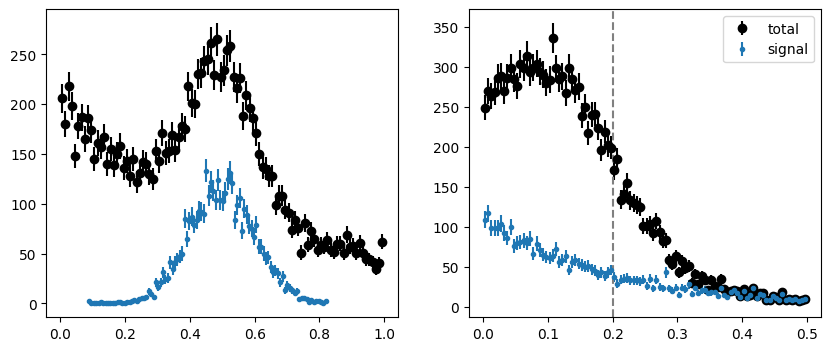

In [46]:
mrange = (0.0, 1.0)
trange = (0.0, 0.5)
tsplit = 0.2

toy = make_classic_toy(
    1, s=4000, b=10000, mrange=mrange, trange=trange, mb_mu=lambda t: 0.1 + 10 * (t / 1.5)
)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax[0])
plot_binned(toy[0], bins=100, color="k", label="total")
plot_binned(toy[0][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.sca(ax[1])
plot_binned(toy[1], bins=100, color="k", label="total")
plot_binned(toy[1][toy[2]], bins=100, marker=".", color="C0", label="signal")
plt.axvline(tsplit, ls="--", color="0.5")
plt.legend();

One can see the factorization violation by eye if the normalized pure background is plotted in intervals of the t-variable. The slopes are different.

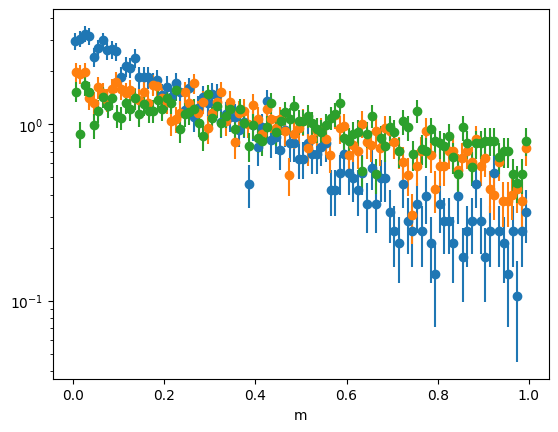

In [47]:
tsplit = np.quantile(toy[1], (0, 0.3, 0.6, 1.0))
for ta, tb in zip(tsplit[:-1], tsplit[1:]):
    m = toy[0][~toy[2]]
    t = toy[1][~toy[2]]
    ma = (ta <= t) & (t < tb)
    plot_binned(m[ma], density=True)
plt.semilogy()
plt.xlabel("m");

As explained in the notebook about factorization tests, one can use Kendall's tau test to detect the non-factorization if a pure background-only sample is available. We can get a background-only sample from the side bands. The p-value is indeed tiny.

In [48]:
ma = (toy[0] < 0.2) | (toy[0] > 0.8)
val, err, pvalue = kendall_tau(toy[0][ma], toy[1][ma])
pvalue

np.float64(4.619421569260017e-68)

Let's ignore the factorization violation and fit the m-distribution to obtain pdfs for signal and background. We model the background with a sum of Bernstein basis polynomials.

In [49]:
bern = make_bernstein_pdf(2, *mrange)

# m-density for fitting and plotting (not normalized)
def m_density(x, s, b1, b2, b3, mu, sigma):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))
    return s / snorm * ds.pdf(x) + b1 * bern[0](x) + b2 * bern[1](x) + b3 * bern[2](x)


# m-model for an extended maximum-likelihood fit, must return...
# - integral as first argument
# - density as second argument
# see iminuit documentation for more information
def m_model(x, s, b1, b2, b3, mu, sigma):
    return (s + b1 + b2 + b3, m_density(x, s, b1, b2, b3, mu, sigma))


mi = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=10000,
    mu=0.5,
    sigma=0.1,
    b1=10000,
    b2=10000,
    b3=10000
)
mi.limits["s", "b1", "b2", "b3"] = (0, None)
mi.limits["mu"] = mrange
mi.limits["sigma"] = (0, None)

mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.413e+05                 │              Nfcn = 249              │
│ EDM = 1.16e-06 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  3.96e3   │  0.22e3   │            │            │    0    │         │       │
│ 1 │ b1    │  6.33e3   │  0.14e3   │            │            │    0    │         │       │
│ 2 │ b2    │   2.0e3   │   0.4e3   │            │            │    0    │         │       │
│ 3 │ b3    │  1.63e3   │  0.10e3   │            │            │    0    │         │       │
│ 4 │ mu    │  0.5006   │  0.0029   │            │            │    0    │    1    │       │
│ 5 │ sigma │   0.100   │   0.004   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────┐
│       │           s          b1          b2          b3          mu       sigma │
├───────┼─────────────────────────────────────────────────────────────────────────┤
│     s │    4.78e+04     0.011e6     -0.07e6        12e3   -1.598e-3  678.308e-3 │
│    b1 │     0.011e6     1.9e+04    -0.030e6         6e3   88.514e-3  146.275e-3 │
│    b2 │     -0.07e6    -0.030e6    1.26e+05       -27e3  -73.260e-3 -988.473e-3 │
│    b3 │        12e3         6e3       -27e3    9.63e+03  -13.657e-3  163.929e-3 │
│    mu │   -1.598e-3   88.514e-3  -73.260e-3  -13.657e-3    8.24e-06       -0e-6 │
│ sigma │  678.308e-3  146.275e-3 -988.473e-3  163.929e-3       -0e-6    1.53e-05 │
└───────┴─────────────────────────────────────────────────────────────────────────┘

We construct the pdfs for signal and background.

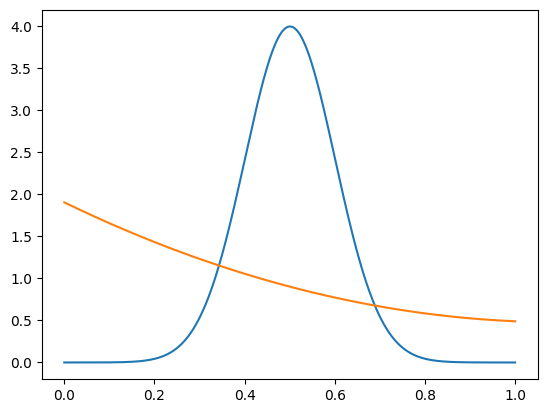

In [50]:
def spdf(m):
    return m_density(m, 1, 0, 0, 0, *mi.values[-2:])


def bpdf(m):
    b1, b2, b3 = mi.values[1:4]
    bt = b1 + b2 + b3
    return m_density(m, 0, b1/bt, b2/bt, b3/bt, *mi.values[-2:])

mp = np.linspace(*mrange, 1000)
plt.plot(mp, spdf(mp))
plt.plot(mp, bpdf(mp));

We construct classic sWeights, COWs with a single background component, and finally COWs with multiple background components. For the last case, we use the Bernstein basis polynomials as background components. As explained in the paper, using multiple background components increases the variance of the weights and reduces the statistical precision of any derived results, but has the potential to avoid the bias from non-factorization.

In [51]:
# compute classic sWeights
sweight = Cows(toy[0], spdf, bpdf, range=mrange)
# compute COWs with integration method, flat norm, and same two components
cow = Cows(None, spdf, bpdf, range=mrange)
# compute classic sWeights with several background components
# nf stands for non-factorizing
sweight_nf = Cows(toy[0], spdf, bern, range=mrange)

We plot the weighted distributions. Only the sWeights computed with multiple background components recover the exponential distribution of the projected signal in the t-variable. The other projections are not exponential.

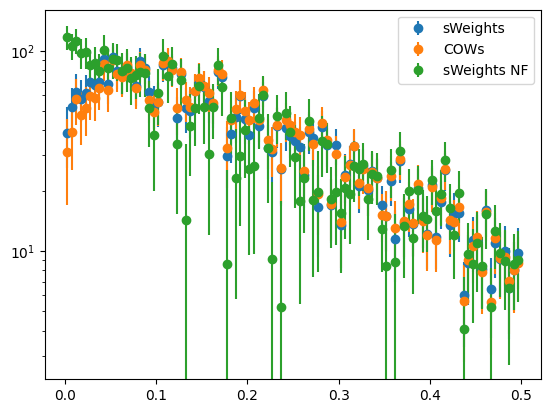

In [52]:
for method, weighter in (
    ("sWeights", sweight),
    ("COWs", cow),
    ("sWeights NF", sweight_nf),
):
    plot_binned(toy[1], weights=weighter(toy[0]), label=method)
plt.semilogy()
plt.legend();

We can also see this with an extended binned fit, which provides us with a chi2 gof test statistic. Only the COWs analysis with multiple background components reproduces the true slope of 0.2 within uncertainties and yields a good fit (chi2/ndof around 1).

In [53]:
from iminuit.cost import ExtendedBinnedNLL

for method, weighter in (("sWeights", sweight), ("COWs", cow), ("sWeights NF", sweight_nf)):
    # get signal weights
    w = weighter(toy[0])

    # do the minimisation

    val, xe = np.histogram(toy[1], weights=w)
    var = np.histogram(toy[1], bins=xe, weights=w**2)[0]

    data = np.transpose((val, var))
    cost = ExtendedBinnedNLL(data, xe, lambda x, n, slope: n * expon.cdf(x, 0, slope))
    tmi = Minuit(cost, n=10000, slope=0.1)
    tmi.limits["n", "slope"] = (0.01, None)
    tmi.migrad()
    tmi.hesse()
    val = tmi.values["slope"]
    err = tmi.errors["slope"]
    print(f"{method:10}: slope = {val:.2f} +/- {err:.2f} "
          f"(chi2/ndof = {tmi.fmin.reduced_chi2:.1f})")

sWeights  : slope = 0.23 +/- 0.01 (chi2/ndof = 5.9)
COWs      : slope = 0.23 +/- 0.01 (chi2/ndof = 8.8)
sWeights NF: slope = 0.20 +/- 0.01 (chi2/ndof = 0.4)
